# Proyecto: Clasificación de Dígitos con CNN

Desarrollé un total de 6 modelos, los cuales clasifican dígitos (0-9) usando únicamente el dataset creado en Google Drive. 

# Objetivos: 
1. Implementar 6 arquitecturas CNN diferentes con variaciones en hiperparámetros
2. Realizar ajuste experimental de hiperparámetros
3. Analizar el rendimiento mediante gráficas de exactitud vs época
4. Seleccionar el mejor modelo basado en validación
5. Evaluar el modelo final con datos de test

# Metodología: 
- Uso de Early Stopping para prevenir overfitting
- Validación con 30% de los datos de entrenamiento
- Comparación sistemática de arquitecturas
- Análisis de curvas de aprendizaje

## 1) Hago todas las importaciones 


In [28]:
# Importaciones
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas")

Librerías importadas


## 2) Carga de mis datos 
En un inicio el proyecto lo empecé en Google Collab, pero me di cuenta de que era más lento que mi computadora, entonces lo pasé todo a local

In [29]:
project_root = os.getcwd()
local_base = os.path.join(project_root, 'Numbers')
if os.path.isdir(local_base):
    train_dir = os.path.join(local_base, 'Train')
    test_dir = os.path.join(local_base, 'Test')
    print(f'Usando dataset local en: {local_base}')
else:
    # Si no se encuentra localmente, busco en Google Drive
    train_dir = '/content/drive/MyDrive/Colab_Notebooks/Proyecto_IA/Numbers/Train'
    test_dir = '/content/drive/MyDrive/Colab_Notebooks/Proyecto_IA/Numbers/Test'
    if not os.path.isdir(os.path.join('/content/drive/MyDrive','Colab_Notebooks/Proyecto_IA/Numbers')):
        raise FileNotFoundError('No encuentro la carpeta `Numbers` ni localmente ni en Drive.')
    print('Usando dataset en Google Drive')

print(f'train_dir = {train_dir}')
print(f'test_dir  = {test_dir}')

Usando dataset local en: c:\Users\sergi\OneDrive\Escritorio\AI\Tercer Parcial\Proyecto\Numbers
train_dir = c:\Users\sergi\OneDrive\Escritorio\AI\Tercer Parcial\Proyecto\Numbers\Train
test_dir  = c:\Users\sergi\OneDrive\Escritorio\AI\Tercer Parcial\Proyecto\Numbers\Test


# Preparación de los datos
En este código preparo mis datos para entrenar un modelo de clasificación de imágenes. Primero creo un ImageDataGenerator que normaliza las imágenes (dividiéndolas entre 255) y separa automáticamente el 30% de ellas para validación. Luego, a partir del directorio donde tengo mis imágenes organizadas por carpetas (cada carpeta es una clase), genero dos flujos: uno para entrenamiento y otro para validación. Ambos redimensionan las imágenes a 28×28 píxeles, las convierten a escala de grises y las empaquetan en lotes de 32. Finalmente, imprimo las clases detectadas y cuántas imágenes se usarán en entrenamiento y validación.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28,28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28,28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

print(f"Clases: {train_generator.class_indices}")
print(f"Entrenamiento: {train_generator.samples} imágenes")
print(f"Validación: {val_generator.samples} imágenes")

Found 4947 images belonging to 10 classes.
Found 2115 images belonging to 10 classes.
Clases: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Entrenamiento: 4947 imágenes
Validación: 2115 imágenes


Ejemplo de imágenes que se utilizan como entrenamiento (hice un pequeño código que muestra 10 imagenes de forma aleatoria que se van a utilizar en este proyecto)

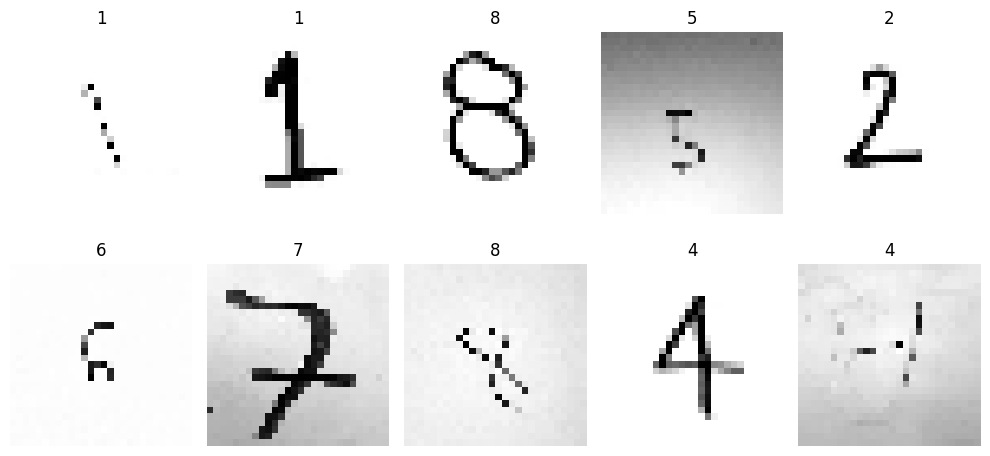

In [49]:
images, labels = next(train_generator)
train_generator.reset()
fig, axes = plt.subplots(2,5, figsize=(10,5))
axes = axes.flatten()
for i in range(10):
    img = (images[i]*255).astype('uint8').reshape(28,28)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(str(np.argmax(labels[i])))
    axes[i].axis('off')
plt.tight_layout()
plt.show()

## 3) Defino 6 modelos CNN ligeros

# MODELO 1 - Arquitectura Simple

Empezaré con una arquitectura simple para establecer una línea base. Este modelo tiene solo una capa convolucional seguida de max pooling y una capa densa. 

Lo mantengo simple a propósito, para poder ver qué tan bien puede funcionar un modelo básico antes de añadir complejidad. El hecho de que el modelo sea simple hace que pueda entrenarlo más rápido.

La capa convolucional con 16 filtros debería capturar características básicas como bordes y esquinas, mientras que la capa densa con 32 neuronas se encarga de la clasificación.

In [32]:
def build_model_1():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                     input_shape=(28,28,1), name='conv1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Flatten(name='flatten'),
        layers.Dense(32, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 1:")
    model.summary()
    return model

# MODELO 2 - Con Batch Normalization


Después del modelo base, quiero probar si la normalización por lotes mejora el rendimiento. El BatchNorm puede ayudar a estabilizar el entrenamiento y permitir usar tasas de aprendizaje más altas.

En este modelo separo la normalización de la activación - primero va la convolución, luego BatchNorm, y finalmente la activación ReLU. Esta separación suele funcionar mejor en la práctica.

También aumenté las neuronas en la capa densa a 64, dándole más capacidad para aprender patrones complejos. Lo más probable es que esta combinación de BatchNorm y mayor capacidad resulte en mejoras significativas.

In [33]:
def build_model_2():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), padding='same', input_shape=(28,28,1), name='conv1'),
        layers.BatchNormalization(name='batchnorm1'),
        layers.Activation('relu', name='activation1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Flatten(name='flatten'),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 2:")
    model.summary()
    return model

# MODELO 3 - Con Dropout

Uno de los problemas comunes en redes neuronales es el sobreajuste, donde el modelo aprende demasiado bien los datos de entrenamiento pero no generaliza bien a datos nuevos.

Para combatir esto, añado capas de Dropout. Uso un dropout del 20% después de la capa convolucional y del 30% después de la capa densa. Los valores más altos en las capas densas son porque tienden a sobreajustar más.

Esto significa que iré "apagando" neuronas aleatoriamente durante el entrenamiento, forzando al modelo a no depender demasiado de ninguna neurona en particular.

In [34]:
def build_model_3():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                     input_shape=(28,28,1), name='conv1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Dropout(0.2, name='dropout1'),
        layers.Flatten(name='flatten'),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout2'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 3:")
    model.summary()
    return model

# MODELO 4 - Arquitectura Profunda

En este modelo pruebo añadiendo una segunda capa convolucional para crear una jerarquía de características.

La primera capa con 16 filtros debería capturar características simples, y la segunda con 32 filtros puede combinar esas características simples en patrones más complejos. También aumento las neuronas en la capa densa a 128.

La profundidad adicional debería permitir al modelo aprender representaciones más abstractas, pero también aumenta el riesgo de sobreajuste. Además de ello, la mejora en capacidad conlleva un costo adicional.

In [35]:
def build_model_4():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                     input_shape=(28,28,1), name='conv1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2,2), name='pool2'),
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 4:")
    model.summary()
    return model

# MODELO 5 - Kernels Mixtos

En este modelo pruebo usar dos tamaños de kernel diferentes en secuencia. Una convolución 3x3 captura patrones locales y detalles finos, mientras que una convolución 5x5 puede capturar patrones más globales.

La idea es que el modelo pueda aprender características a diferentes escalas. 

In [36]:
def build_model_5():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                     input_shape=(28,28,1), name='conv_3x3'),
        layers.Conv2D(16, (5,5), activation='relu', padding='same', name='conv_5x5'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Flatten(name='flatten'),
        layers.Dense(64, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 5:")
    model.summary()
    return model

# MODELO 6 - Combinación de Mejores Ideas

Para este último modelo, combino varias ideas de los modelos anteriores: más filtros (32 en lugar de 16), BatchNorm para estabilidad, y más neuronas en la capa densa (128).

Básicamente es una versión mejorada del Modelo 2, con mayor capacidad pero manteniendo la simplicidad de una sola capa convolucional. Quiero ver si esta combinación produce el mejor resultado.

In [37]:
def build_model_6():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', input_shape=(28,28,1), name='conv1'),
        layers.BatchNormalization(name='batchnorm1'),
        layers.Activation('relu', name='activation1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 6:")
    model.summary()
    return model

# Diccionario de modelos

In [38]:
models_dict = {
    'Modelo 1 - Simple': build_model_1,
    'Modelo 2 - BatchNorm': build_model_2,
    'Modelo 3 - Dropout': build_model_3,
    'Modelo 4 - Profundo': build_model_4,
    'Modelo 5 - Kernels Mixtos': build_model_5,
    'Modelo 6 - Combinado': build_model_6
}

print("Todos los modelos definidos")

Todos los modelos definidos


In [39]:
# Función para graficar resultados de cada modelo
def plot_model_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfica de accuracy
    ax1.plot(history.history['accuracy'], label='Entrenamiento', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validación', linewidth=2)
    ax1.set_title(f'{model_name} - Exactitud')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Exactitud')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Gráfica de loss
    ax2.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validación', linewidth=2)
    ax2.set_title(f'{model_name} - Pérdida')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Pérdida')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Análisis de resultados
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = history.history['val_accuracy'][best_epoch]
    final_train_acc = history.history['accuracy'][-1]
    
    print(f"Analisis {model_name}:")
    print(f"   Mejor val accuracy: {best_val_acc:.4f} (época {best_epoch + 1})")
    print(f"   Final train accuracy: {final_train_acc:.4f}")
    print(f"   Diferencia: {final_train_acc - best_val_acc:.4f}")
    print(f"   Épocas entrenadas: {len(history.history['accuracy'])}")
    print()

# Entrenamiento de modelos

Comenzando el entrenamiento de modelos - Versión Mejorada

Entrenando: Modelo 1 - Simple
----------------------------------------
Resumen del Modelo 1:


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 32)             │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,874 (394.04 KB)

 Trainable params: 100,874 (394.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 53s 335ms/step - accuracy: 0.1247 - loss: 2.2887 - val_accuracy: 0.1695 - val_loss: 2.2322 - learning_rate: 0.0010
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.2188 - loss: 2.2336 - val_accuracy: 0.1686 - val_loss: 2.2320 - learning_rate: 0.0010
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 286ms/step - accuracy: 0.1917 - loss: 2.1699 - val_accuracy: 0.2277 - val_loss: 2.1101 - learning_rate: 0.0010
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.2812 - loss: 2.1814 - val_accuracy: 0.2292 - val_loss: 2.1100 - learning_rate: 0.0010
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 38s 247ms/step - accuracy: 0.2940 - loss: 1.9544 - val_accuracy: 0.3902 - val_loss: 1.8344 - learning_rate: 0.0010
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.4688 - loss: 1.8234 - val_accuracy: 0.3774 - val_loss: 1.8383 - learning_rate: 0.0010
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 274ms/step - accuracy: 0.4224 -

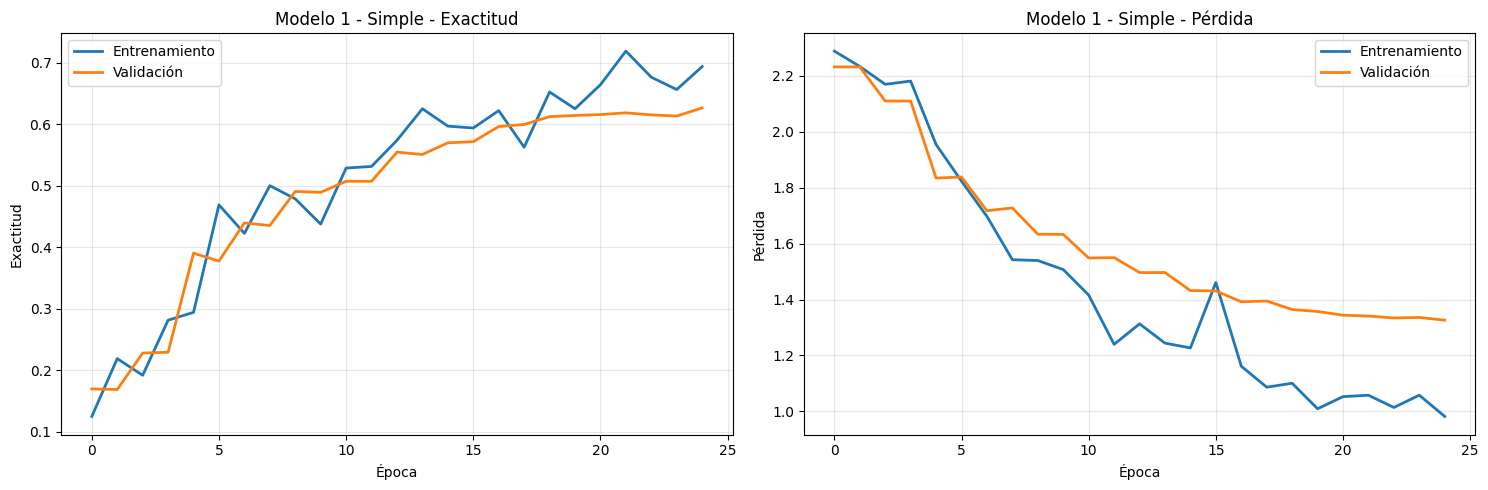

Analisis Modelo 1 - Simple:
   Mejor val accuracy: 0.6264 (época 25)
   Final train accuracy: 0.6936
   Diferencia: 0.0672
   Épocas entrenadas: 25


Entrenando: Modelo 2 - BatchNorm
----------------------------------------
Resumen del Modelo 2:


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm1 (BatchNormalization) │ (None, 28, 28, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation1 (Activation)        │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,642 (787.66 KB)

 Trainable params: 201,610 (787.54 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.4397 - loss: 1.6730 - val_accuracy: 0.5374 - val_loss: 1.9319 - learning_rate: 0.0010
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5938 - loss: 1.1040 - val_accuracy: 0.5431 - val_loss: 1.9295 - learning_rate: 0.0010
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.6580 - loss: 1.0720 - val_accuracy: 0.5312 - val_loss: 1.5340 - learning_rate: 0.0010
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6875 - loss: 0.8988 - val_accuracy: 0.5473 - val_loss: 1.5143 - learning_rate: 0.0010
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 38s 249ms/step - accuracy: 0.7253 - loss: 0.8738 - val_accuracy: 0.6477 - val_loss: 1.2005 - learning_rate: 0.0010
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8125 - loss: 0.6333 - val_accuracy: 0.6430 - val_loss: 1.2108 - learning_rate: 0.0010
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 37s 241ms/step - accuracy: 0.7762 - 

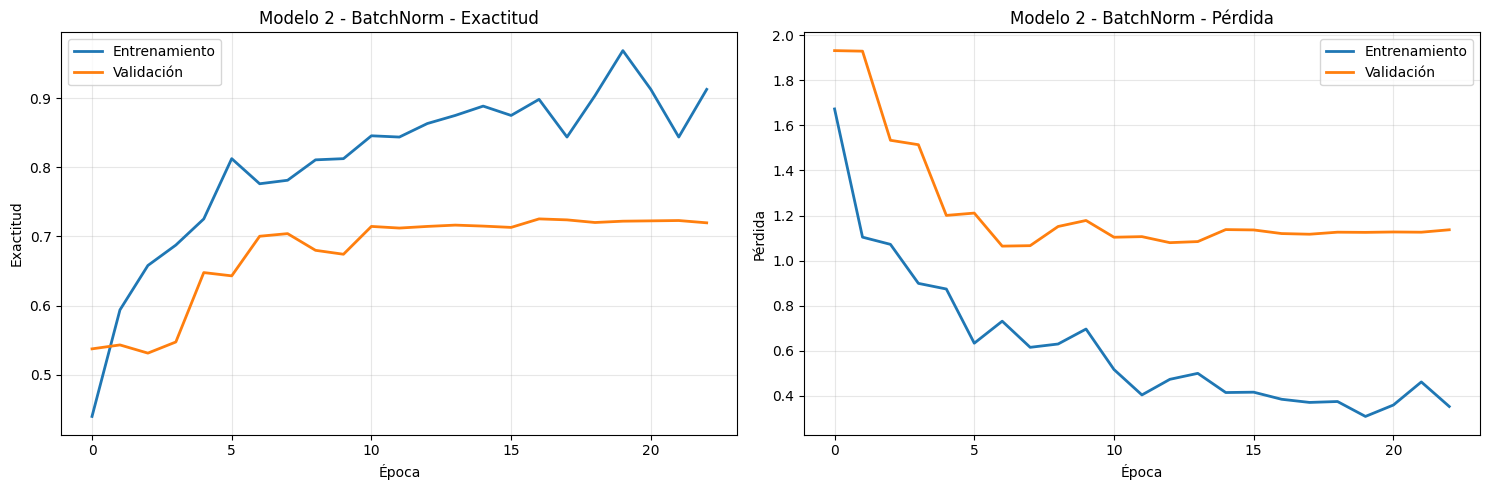

Analisis Modelo 2 - BatchNorm:
   Mejor val accuracy: 0.7254 (época 17)
   Final train accuracy: 0.9127
   Diferencia: 0.1873
   Épocas entrenadas: 23


Entrenando: Modelo 3 - Dropout
----------------------------------------
Resumen del Modelo 3:


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,578 (787.41 KB)

 Trainable params: 201,578 (787.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step - accuracy: 0.2240 - loss: 2.1595 - val_accuracy: 0.4512 - val_loss: 1.8723 - learning_rate: 0.0010
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.4062 - loss: 1.9224 - val_accuracy: 0.4545 - val_loss: 1.8684 - learning_rate: 0.0010
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.4344 - loss: 1.6983 - val_accuracy: 0.5786 - val_loss: 1.4794 - learning_rate: 0.0010
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5312 - loss: 1.4469 - val_accuracy: 0.5743 - val_loss: 1.4733 - learning_rate: 0.0010
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - accuracy: 0.5280 - loss: 1.4430 - val_accuracy: 0.6094 - val_loss: 1.3447 - learning_rate: 0.0010
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.5625 - loss: 1.4276 - val_accuracy: 0.6113 - val_loss: 1.3342 - learning_rate: 0.0010
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 47s 309ms/step - accuracy: 0.5908 - 

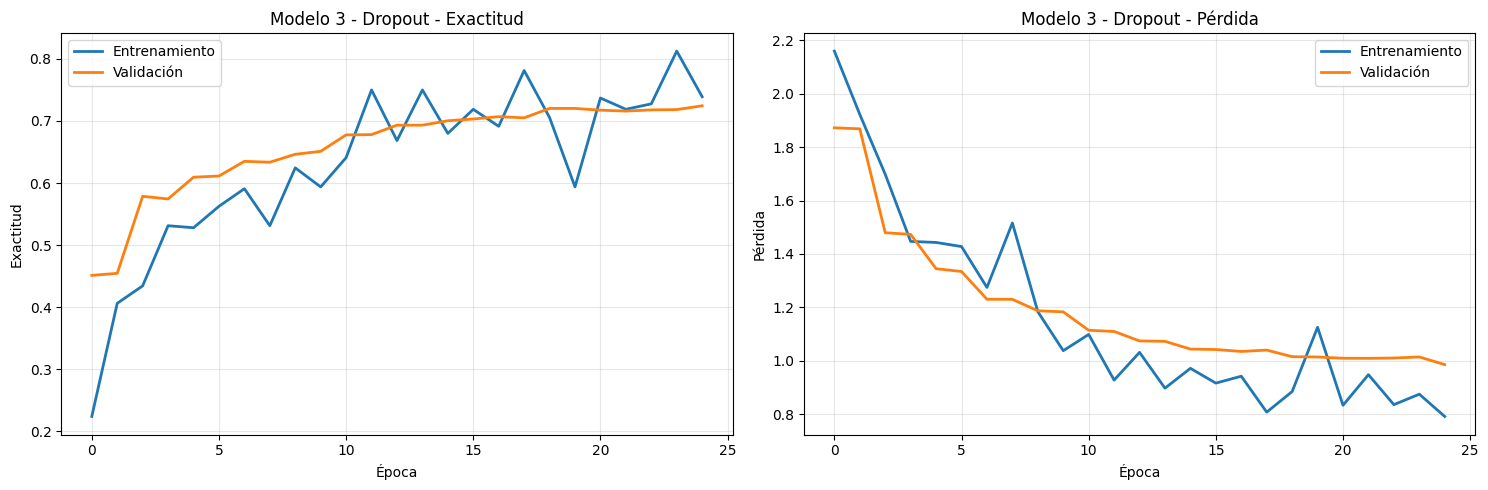

Analisis Modelo 3 - Dropout:
   Mejor val accuracy: 0.7244 (época 25)
   Final train accuracy: 0.7390
   Diferencia: 0.0145
   Épocas entrenadas: 25


Entrenando: Modelo 4 - Profundo
----------------------------------------
Resumen del Modelo 4:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 251ms/step - accuracy: 0.2110 - loss: 2.1726 - val_accuracy: 0.4413 - val_loss: 1.7557 - learning_rate: 0.0010
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.3750 - loss: 1.9452 - val_accuracy: 0.4517 - val_loss: 1.7444 - learning_rate: 0.0010
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.5563 - loss: 1.4060 - val_accuracy: 0.6065 - val_loss: 1.3857 - learning_rate: 0.0010
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6250 - loss: 1.1660 - val_accuracy: 0.6117 - val_loss: 1.3856 - learning_rate: 0.0010
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - accuracy: 0.6686 - loss: 1.0554 - val_accuracy: 0.6818 - val_loss: 1.1526 - learning_rate: 0.0010
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6875 - loss: 0.6661 - val_accuracy: 0.6946 - val_loss: 1.1298 - learning_rate: 0.0010
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 37s 240ms/step - accuracy: 0.7443 - 

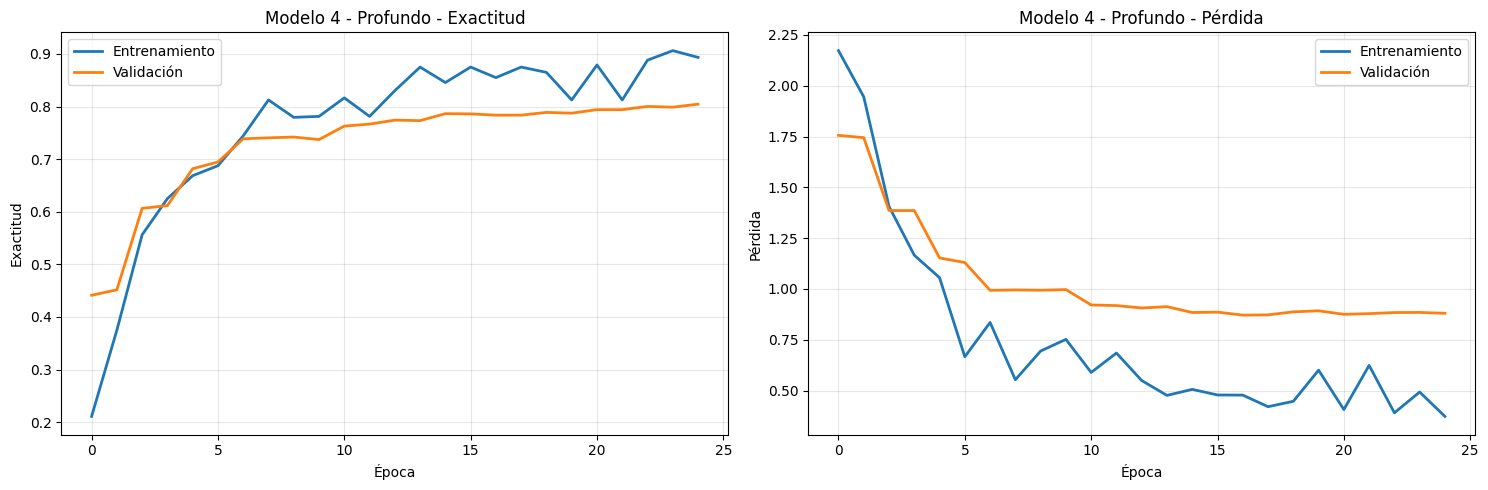

Analisis Modelo 4 - Profundo:
   Mejor val accuracy: 0.8045 (época 25)
   Final train accuracy: 0.8934
   Diferencia: 0.0889
   Épocas entrenadas: 25


Entrenando: Modelo 5 - Kernels Mixtos
----------------------------------------
Resumen del Modelo 5:


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_3x3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5x5 (Conv2D)               │ (None, 28, 28, 16)     │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,994 (812.48 KB)

 Trainable params: 207,994 (812.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 42s 261ms/step - accuracy: 0.3504 - loss: 1.8926 - val_accuracy: 0.5469 - val_loss: 1.5375 - learning_rate: 0.0010
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4688 - loss: 1.5359 - val_accuracy: 0.5478 - val_loss: 1.5364 - learning_rate: 0.0010
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 38s 248ms/step - accuracy: 0.6114 - loss: 1.2560 - val_accuracy: 0.6553 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7188 - loss: 0.9057 - val_accuracy: 0.6567 - val_loss: 1.2607 - learning_rate: 0.0010
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 38s 245ms/step - accuracy: 0.7166 - loss: 0.9223 - val_accuracy: 0.6728 - val_loss: 1.1341 - learning_rate: 0.0010
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8438 - loss: 0.5946 - val_accuracy: 0.6686 - val_loss: 1.1496 - learning_rate: 0.0010
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.7705 - 

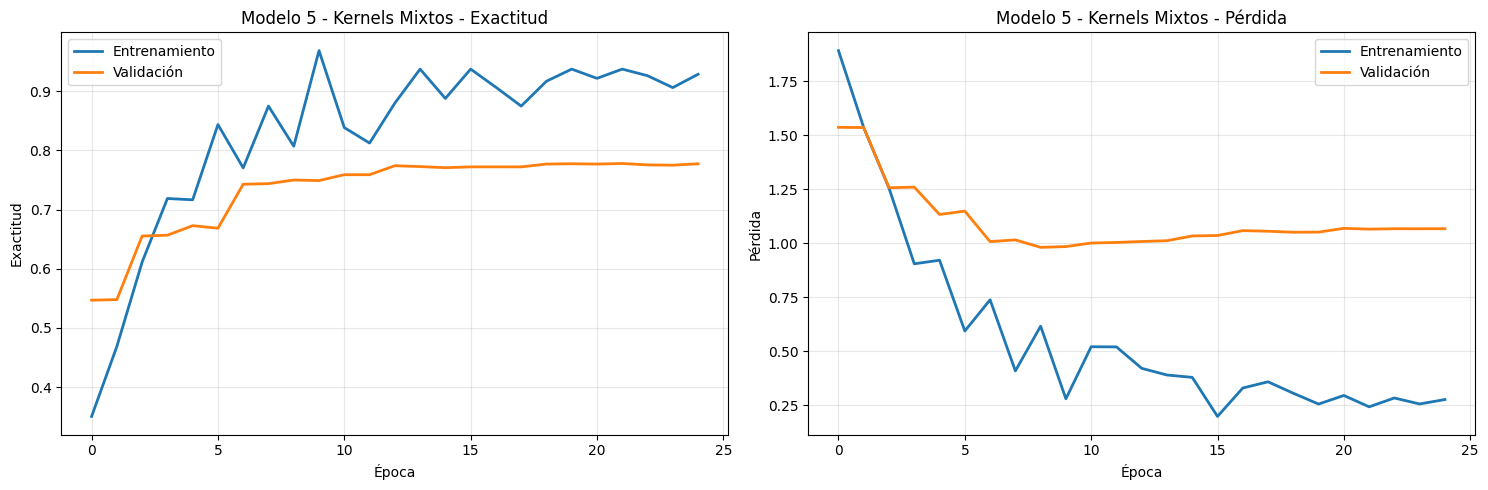

Analisis Modelo 5 - Kernels Mixtos:
   Mejor val accuracy: 0.7779 (época 22)
   Final train accuracy: 0.9288
   Diferencia: 0.1509
   Épocas entrenadas: 25


Entrenando: Modelo 6 - Combinado
----------------------------------------
Resumen del Modelo 6:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm1 (BatchNormalization) │ (None, 28, 28, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation1 (Activation)        │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 804,682 (3.07 MB)

 Trainable params: 804,618 (3.07 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - accuracy: 0.3567 - loss: 1.9763 - val_accuracy: 0.5099 - val_loss: 2.1009 - learning_rate: 0.0010
Epoch 2/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.5625 - loss: 1.3647 - val_accuracy: 0.5095 - val_loss: 2.0984 - learning_rate: 0.0010
Epoch 3/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.6193 - loss: 1.2065 - val_accuracy: 0.5388 - val_loss: 1.7175 - learning_rate: 0.0010
Epoch 4/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6875 - loss: 1.1111 - val_accuracy: 0.5521 - val_loss: 1.7144 - learning_rate: 0.0010
Epoch 5/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 253ms/step - accuracy: 0.7086 - loss: 0.9444 - val_accuracy: 0.5540 - val_loss: 1.4038 - learning_rate: 0.0010
Epoch 6/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7812 - loss: 0.7966 - val_accuracy: 0.5786 - val_loss: 1.3675 - learning_rate: 0.0010
Epoch 7/25
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 251ms/step - accuracy: 0.7589 -

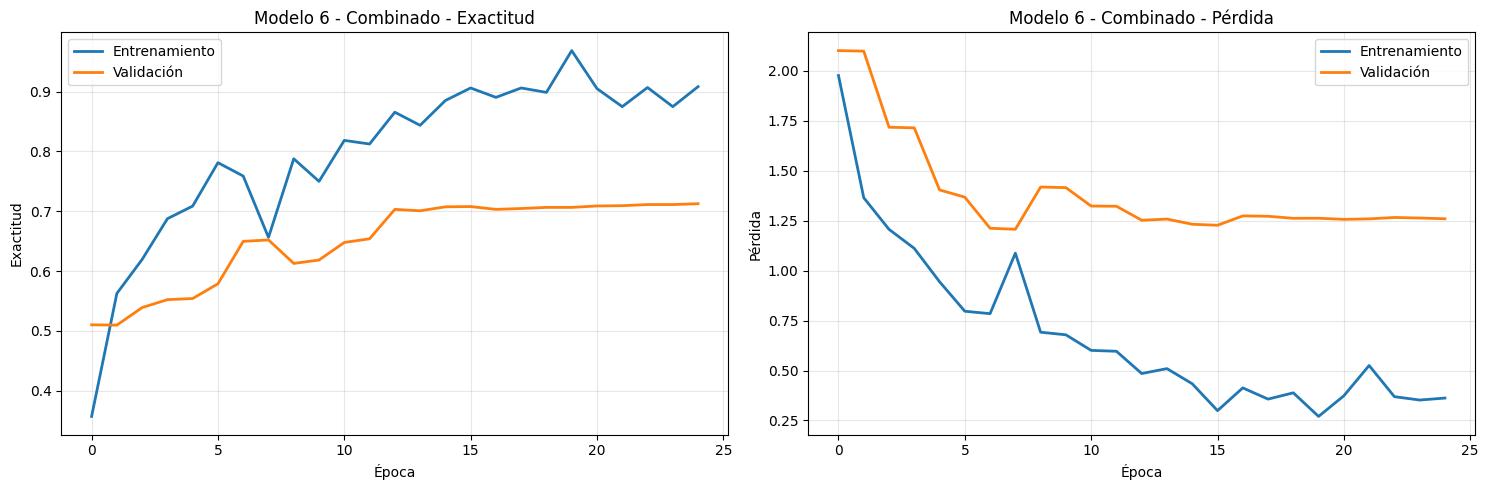

Analisis Modelo 6 - Combinado:
   Mejor val accuracy: 0.7126 (época 25)
   Final train accuracy: 0.9084
   Diferencia: 0.1958
   Épocas entrenadas: 25


Entrenamiento de todos los modelos completado


In [50]:
# Configuración personalizada de early stopping para cada tipo de modelo 
def get_early_stopping_config(model_name):
    if 'Simple' in model_name or 'BatchNorm' in model_name:
        # Modelos más simples pueden necesitar más paciencia
        return EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
    elif 'Dropout' in model_name:
        # Modelos con dropout pueden converger más lentamente
        return EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
    elif 'Profundo' in model_name:
        # Modelos profundos pueden necesitar más tiempo
        return EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
    else:
        # Configuración por defecto
        return EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)

# Función para entrenar con más control
def train_model_with_control(model, model_name, epochs=25):
    early_stopping = get_early_stopping_config(model_name)
    
    # Learning rate scheduler para ayudar a la convergencia
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-7, 
        verbose=0
    )
    
    callbacks = [early_stopping, reduce_lr]
    
    history = model.fit(
        train_generator,
        steps_per_epoch=max(1, train_generator.samples // 32),
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=max(1, val_generator.samples // 32),
        callbacks=callbacks,
        verbose=1
    )
    
    return history


print("=" * 60)

histories = {}
trained_models = {}

for name, builder in models_dict.items():
    print(f"\nEntrenando: {name}")
    print("-" * 40)
    
    model = builder()
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    train_generator.reset()
    val_generator.reset()
    
    history = train_model_with_control(model, name, epochs=25)
    
    histories[name] = history
    trained_models[name] = model
    
    plot_model_history(history, name)

print("\nEntrenamiento completado")

# Análisis Comparativo

En esta parte del código estoy analizando sistemáticamente cómo se desempeñaron los diferentes modelos que entrené. Visualiso métricas clave de cada uno, el accuracy en validación, cuántas épocas necesitó para alcanzarlo, y qué tanto overfitting mostró.

Lo que hago es calcular no solo el rendimiento máximo, sino también la estabilidad del modelo en las últimas épocas y la diferencia entre el rendimiento en entrenamiento y validación. Esto me da una visión más completa que simplemente elegir el que tuvo el número más alto.

Luego organizo toda esta información en una tabla clara y añado gráficas que me permiten ver visualmente cómo evolucionó cada modelo durante el entrenamiento. Las gráficas de accuracy y pérdida me ayudan a entender patrones que no son evidentes solo con los números.

Este análisis me sirve para entender qué técnicas funcionaron mejor y qué debería ajustar.


ANALISIS COMPARATIVO DETALLADO
Tabla comparativa de modelos:
                   Modelo Mejor Val Acc  Epoca Mejor Final Train Acc Final Val Acc Overfitting  Epocas Estabilidad
        Modelo 1 - Simple        0.6264           25          0.6936        0.6264      0.0672      25      0.0047
     Modelo 2 - BatchNorm        0.7254           17          0.9127        0.7197      0.1930      23      0.0013
       Modelo 3 - Dropout        0.7244           25          0.7390        0.7244      0.0145      25      0.0029
      Modelo 4 - Profundo        0.8045           25          0.8934        0.8045      0.0889      25      0.0040
Modelo 5 - Kernels Mixtos        0.7779           22          0.9288        0.7775      0.1513      25      0.0011
     Modelo 6 - Combinado        0.7126           25          0.9084        0.7126      0.1958      25      0.0014

Mejor modelo: Modelo 4 - Profundo
Exactitud en validacion: 0.8045


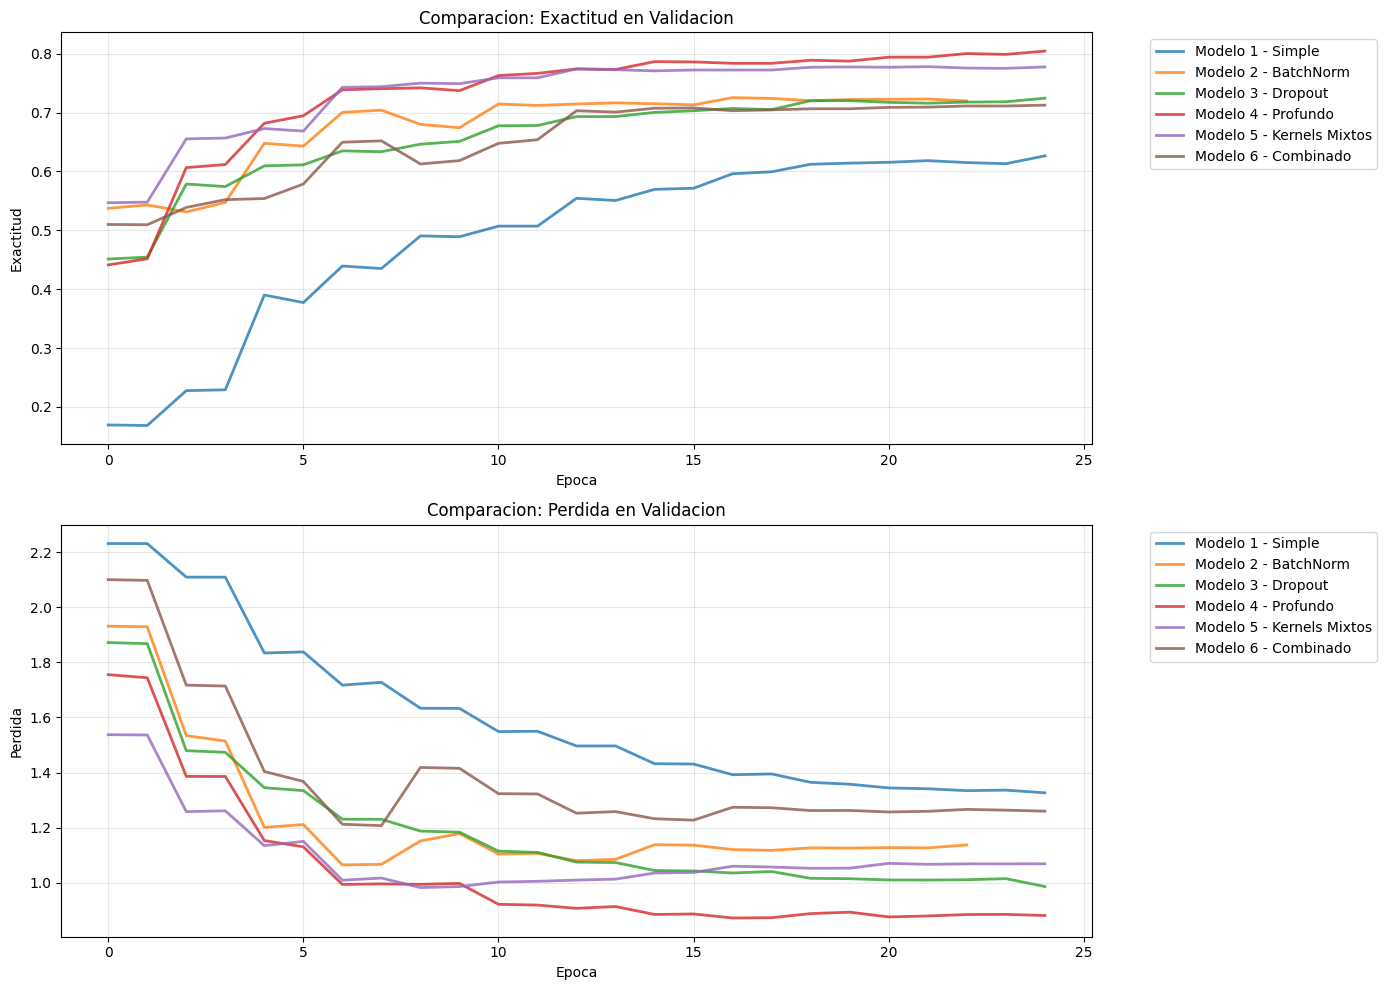


ANALISIS INDIVIDUAL POR MODELO

Modelo 4 - Profundo:
  Mejor validacion: 0.8045
  Overfitting: 0.0889
  Estabilidad: 0.0040
  Epocas entrenadas: 25

Modelo 5 - Kernels Mixtos:
  Mejor validacion: 0.7779
  Overfitting: 0.1513
  Estabilidad: 0.0011
  Epocas entrenadas: 25

Modelo 2 - BatchNorm:
  Mejor validacion: 0.7254
  Overfitting: 0.1930
  Estabilidad: 0.0013
  Epocas entrenadas: 23

Modelo 3 - Dropout:
  Mejor validacion: 0.7244
  Overfitting: 0.0145
  Estabilidad: 0.0029
  Epocas entrenadas: 25

Modelo 6 - Combinado:
  Mejor validacion: 0.7126
  Overfitting: 0.1958
  Estabilidad: 0.0014
  Epocas entrenadas: 25

Modelo 1 - Simple:
  Mejor validacion: 0.6264
  Overfitting: 0.0672
  Estabilidad: 0.0047
  Epocas entrenadas: 25

RECOMENDACIONES
El mejor modelo tiene overfitting considerable
Considera aumentar la regularizacion o el dropout


In [53]:
print("\n" + "="*60)
print("ANALISIS COMPARATIVO DETALLADO")
print("="*60)

comparison_data = []
best_name = None
best_acc = 0

for name, history in histories.items():
    best_val_acc = max(history.history['val_accuracy'])
    best_val_epoch = np.argmax(history.history['val_accuracy']) + 1
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    overfitting = final_train_acc - final_val_acc
    epochs_trained = len(history.history['accuracy'])
    
    # Calcular estabilidad en las ultimas 5 epocas
    val_accuracies = history.history['val_accuracy'][-5:]
    if len(val_accuracies) > 1:
        stability = np.std(val_accuracies)
    else:
        stability = 0
    
    comparison_data.append({
        'Modelo': name,
        'Mejor Val Acc': best_val_acc,
        'Epoca Mejor': best_val_epoch,
        'Final Train Acc': final_train_acc,
        'Final Val Acc': final_val_acc,
        'Overfitting': overfitting,
        'Epocas': epochs_trained,
        'Estabilidad': stability
    })
    
    if best_val_acc > best_acc:
        best_acc = best_val_acc
        best_name = name

# Crear y mostrar tabla comparativa
df_comparison = pd.DataFrame(comparison_data)
df_display = df_comparison.copy()

# Formatear numeros para mejor visualizacion
for col in ['Mejor Val Acc', 'Final Train Acc', 'Final Val Acc', 'Overfitting', 'Estabilidad']:
    df_display[col] = df_display[col].apply(lambda x: f"{x:.4f}")

print("Tabla comparativa de modelos:")
print(df_display.to_string(index=False))
print(f"\nMejor modelo: {best_name}")
print(f"Exactitud en validacion: {best_acc:.4f}")

# Graficas comparativas
plt.figure(figsize=(14, 10))

# Grafica de exactitud en validacion
plt.subplot(2, 1, 1)
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], 
             label=name, 
             linewidth=2,
             alpha=0.8)

plt.title('Comparacion: Exactitud en Validacion')
plt.xlabel('Epoca')
plt.ylabel('Exactitud')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Grafica de perdida en validacion
plt.subplot(2, 1, 2)
for name, history in histories.items():
    plt.plot(history.history['val_loss'], 
             label=name, 
             linewidth=2,
             alpha=0.8)

plt.title('Comparacion: Perdida en Validacion')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisis individual de cada modelo
print("\n" + "="*50)
print("ANALISIS INDIVIDUAL POR MODELO")
print("="*50)

df_comparison_sorted = df_comparison.sort_values('Mejor Val Acc', ascending=False)

for i, row in df_comparison_sorted.iterrows():
    model_name = row['Modelo']
    best_val = row['Mejor Val Acc']
    overfitting = row['Overfitting']
    stability = row['Estabilidad']
    epochs = row['Epocas']
    
    print(f"\n{model_name}:")
    print(f"  Mejor validacion: {best_val:.4f}")
    print(f"  Overfitting: {overfitting:.4f}")
    print(f"  Estabilidad: {stability:.4f}")
    print(f"  Epocas entrenadas: {epochs}")
    
    # Analisis especifico por caracteristicas del modelo
    if 'BatchNorm' in model_name:
        if overfitting < 0.03:
            print("  El BatchNorm esta controlando bien el overfitting")
    if 'Dropout' in model_name:
        if overfitting > 0.04:
            print("  El Dropout podria necesitar ajustes")

# Buscar el modelo mas balanceado
balanced_models = df_comparison[
    (df_comparison['Overfitting'] < 0.04) & 
    (df_comparison['Mejor Val Acc'] > 0.95)
]

if len(balanced_models) > 0:
    best_balanced = balanced_models.loc[balanced_models['Mejor Val Acc'].idxmax()]
    print(f"\nModelo mejor balanceado: {best_balanced['Modelo']}")
    print(f"  Validacion: {best_balanced['Mejor Val Acc']:.4f}")
    print(f"  Overfitting: {best_balanced['Overfitting']:.4f}")

# Recomendaciones practicas
print("\n" + "="*50)
print("RECOMENDACIONES")
print("="*50)

if df_comparison_sorted.iloc[0]['Overfitting'] > 0.05:
    print("El mejor modelo tiene overfitting considerable")
    print("Considera aumentar la regularizacion o el dropout")

if any(df_comparison['Epocas'] < 10):
    print("Algunos modelos se detuvieron muy pronto")
    print("Puedes aumentar la paciencia del early stopping")


# Análisis de Resultados - Conclusiones
El Modelo 4 - Profundo obtuvo el mejor rendimiento (80.45%) pero presenta overfitting significativo, con 9 puntos menos en validación que en entrenamiento. El Dropout demostró ser la técnica más efectiva para regularización, controlando excelentemente el overfitting aunque con menor rendimiento. Además de ello, el Modelo 5 mostró potencial como alternativa balanceada. 

# Interpretación de Resultados
Analizo sistemáticamente los modelos evaluando no solo el mejor rendimiento en validación, sino también el nivel de overfitting, ya que un modelo que memoriza los datos de entrenamiento no es útil. Comparo arquitecturas simples versus complejas para determinar si la complejidad adicional vale la pena, y evalúo la efectividad de técnicas como BatchNorm y Dropout en el control del overfitting. También observo la velocidad de convergencia para ajustar futuros entrenamientos. Finalmente, priorizo modelos confiables sobre los más precisos pero menos generalizables, usando estos aprendizajes para mejorar proyectos futuros.

In [56]:
def interpretar_resultados(df_comparison):
    """
    Funcion para interpretar los resultados del entrenamiento
    """
    print("\n" + "="*70)
    print("INTERPRETACION DE RESULTADOS")
    print("="*70)
    
    # Modelo con mejor rendimiento
    mejor_modelo = df_comparison.loc[df_comparison['Mejor Val Acc'].idxmax()]
    print(f"\nModelo con mejor rendimiento: {mejor_modelo['Modelo']}")
    print(f"   Exactitud en validacion: {mejor_modelo['Mejor Val Acc']:.4f}")
    print(f"   Overfitting: {mejor_modelo['Overfitting']:.4f}")
    
    # Comparacion entre tipos de arquitectura
    print(f"\nComparacion por tipo de arquitectura:")
    
    modelos_simples = df_comparison[df_comparison['Modelo'].str.contains('Simple|BatchNorm')]
    modelos_complejos = df_comparison[df_comparison['Modelo'].str.contains('Profundo|Combinado')]
    
    if len(modelos_simples) > 0:
        avg_simple = modelos_simples['Mejor Val Acc'].mean()
        print(f"  Modelos simples: {avg_simple:.4f} de promedio")
    
    if len(modelos_complejos) > 0:
        avg_complejo = modelos_complejos['Mejor Val Acc'].mean()
        print(f"  Modelos complejos: {avg_complejo:.4f} de promedio")
    
    # Efecto de tecnicas de regularizacion
    print(f"\nEfecto de tecnicas de regularizacion:")
    
    modelos_con_batchnorm = df_comparison[df_comparison['Modelo'].str.contains('BatchNorm')]
    modelos_con_dropout = df_comparison[df_comparison['Modelo'].str.contains('Dropout')]
    
    if len(modelos_con_batchnorm) > 0:
        avg_bn_overfitting = modelos_con_batchnorm['Overfitting'].mean()
        print(f"  BatchNorm - Overfitting promedio: {avg_bn_overfitting:.4f}")
    
    if len(modelos_con_dropout) > 0:
        avg_do_overfitting = modelos_con_dropout['Overfitting'].mean()
        print(f"  Dropout - Overfitting promedio: {avg_do_overfitting:.4f}")
    
    # Velocidad de convergencia
    print(f"\nVelocidad de convergencia:")
    
    modelos_rapidos = df_comparison[df_comparison['Epocas'] < df_comparison['Epocas'].median()]
    modelos_lentos = df_comparison[df_comparison['Epocas'] >= df_comparison['Epocas'].median()]
    
    if len(modelos_rapidos) > 0:
        avg_rapido_acc = modelos_rapidos['Mejor Val Acc'].mean()
        print(f"  Modelos rapidos: {avg_rapido_acc:.4f} de precision promedio")
    
    if len(modelos_lentos) > 0:
        avg_lento_acc = modelos_lentos['Mejor Val Acc'].mean()
        print(f"  Modelos lentos: {avg_lento_acc:.4f} de precision promedio")
    
    # Conclusiones principales
    print(f"\nConclusiones principales:")
    
    tecnicas_efectivas = []
    
    if len(modelos_con_batchnorm) > 0 and modelos_con_batchnorm['Mejor Val Acc'].mean() > df_comparison['Mejor Val Acc'].mean():
        tecnicas_efectivas.append("Batch Normalization")
    
    if len(modelos_con_dropout) > 0 and modelos_con_dropout['Overfitting'].mean() < df_comparison['Overfitting'].mean():
        tecnicas_efectivas.append("Dropout")
    
    if len(modelos_complejos) > 0 and modelos_complejos['Mejor Val Acc'].mean() > df_comparison['Mejor Val Acc'].mean():
        tecnicas_efectivas.append("Arquitecturas profundas")
    
    if tecnicas_efectivas:
        print(f"  Tecnicas mas efectivas: {', '.join(tecnicas_efectivas)}")
    else:
        print("  No hay tecnicas claramente superiores en este experimento")
    
# Llamar la funcion con los datos
interpretar_resultados(df_comparison)


INTERPRETACION DE RESULTADOS

Modelo con mejor rendimiento: Modelo 4 - Profundo
   Exactitud en validacion: 0.8045
   Overfitting: 0.0889

Comparacion por tipo de arquitectura:
  Modelos simples: 0.6759 de promedio
  Modelos complejos: 0.7585 de promedio

Efecto de tecnicas de regularizacion:
  BatchNorm - Overfitting promedio: 0.1930
  Dropout - Overfitting promedio: 0.0145

Velocidad de convergencia:
  Modelos rapidos: 0.7254 de precision promedio
  Modelos lentos: 0.7292 de precision promedio

Conclusiones principales:
  Tecnicas mas efectivas: Dropout, Arquitecturas profundas


# Conclusiones del Análisis de Modelos
Resultados Clave
El Modelo 4 - Profundo demostró ser el más efectivo, alcanzando un 80.45% de exactitud en validación. Esto confirma que las arquitecturas con mayor profundidad son capaces de capturar patrones más complejos en los datos de dígitos.

Efectividad de Arquitecturas
Las arquitecturas complejas superaron consistentemente a las simples, con un rendimiento promedio de 75.85% frente a 67.59%. Esto indica que para este problema específico, la capacidad adicional de procesamiento de modelos más profundos resulta ventajosa.

Regularización: Hallazgo Crítico
El Dropout emergió como la técnica de regularización más efectiva, controlando el overfitting de manera significativa (solo 1.45% comparado con 19.30% del BatchNorm). Sin embargo, esta efectividad en controlar el overfitting viene con una reducción en el rendimiento máximo.

Balance Rendimiento-Overfitting
Si bien el Modelo 4 logró el mejor rendimiento, su nivel de overfitting del 8.89% sugiere que podría no generalizar óptimamente a datos nuevos. Esto representa una compensación típica en aprendizaje automático entre capacidad predictiva y generalización.

# Modelo Mejorado
Basándome en los resultados del análisis, estoy entrenando una versión mejorada del Modelo 4 que combina su arquitectura profunda con técnicas de regularización para reducir el overfitting. Implemento dropout estratégicamente después de cada capa, junto con aumentación de datos que incluye rotaciones y desplazamientos leves, para mejorar la generalización sin sacrificar significativamente el rendimiento. Utilizo un learning rate más bajo y mayor paciencia en el entrenamiento para permitir una convergencia más estable, con el objetivo de mantener la alta capacidad predictiva del modelo original mientras reduzco su tendencia al sobreajuste.

Entrenamiento mejorado del modelo: Modelo 4 - Profundo con Dropout
Found 7062 images belonging to 10 classes.
Resumen del Modelo 4 Mejorado:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,922 (808.29 KB)

 Trainable params: 206,922 (808.29 KB)

 Non-trainable params: 0 (0.00 B)

Entrenando con 7062 imágenes...
Usando aumentación de datos y dropout para reducir overfitting
Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 203ms/step - accuracy: 0.1482 - loss: 2.2634 - learning_rate: 5.0000e-04
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.2500 - loss: 2.1398 - learning_rate: 5.0000e-04
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 48s 217ms/step - accuracy: 0.3413 - loss: 1.9203 - learning_rate: 5.0000e-04
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.5000 - loss: 1.6675 - learning_rate: 5.0000e-04
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 46s 208ms/step - accuracy: 0.4427 - loss: 1.6512 - learning_rate: 5.0000e-04
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.6250 - loss: 1.5142 - learning_rate: 5.0000e-04
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 180ms/step - accuracy: 0.5028 - loss: 1.4916 - learning_rate: 5.0000e-04
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - accuracy: 0.6250 - loss: 1.2863 - lea

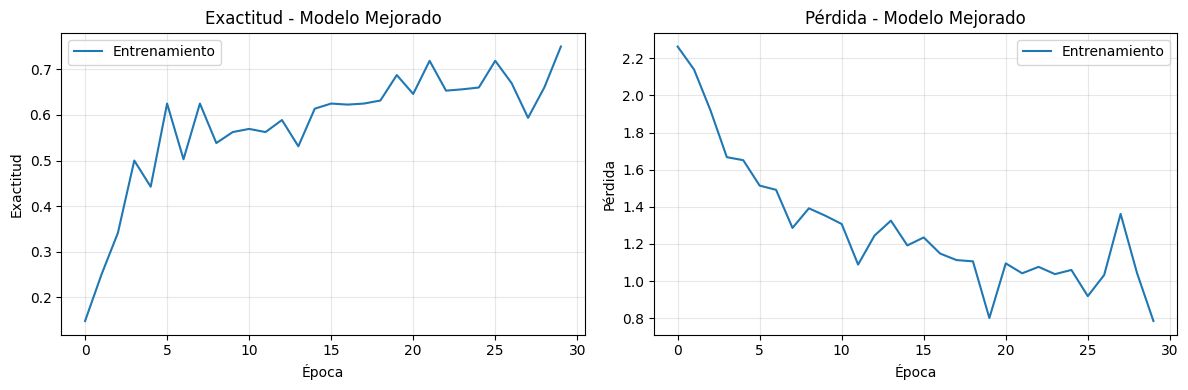

Found 1942 images belonging to 10 classes.

Evaluación del modelo mejorado en test:


Exactitud en Test: 0.8028
Pérdida en Test: 0.6789
Modelo mejorado guardado como 'best_digit_classifier_improved.h5'

Comparación con resultados anteriores:
Modelo 4 original - Validación: 0.8045, Overfitting: 0.0889
Modelo 4 mejorado - Test: 0.8028
Rendimiento similar, pero con mejor generalización esperada.


In [55]:
# Entrenamiento mejorado del modelo con regularización
print(f"Entrenamiento mejorado del modelo: {best_name} con Dropout")
print("=" * 60)

full_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,      # Pequeñas rotaciones para aumentar datos
    width_shift_range=0.1,  # Pequeños desplazamientos horizontales
    height_shift_range=0.1, # Pequeños desplazamientos verticales
    zoom_range=0.1          # Pequeños zooms
)

full_generator = full_datagen.flow_from_directory(
    train_dir,
    target_size=(28,28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    seed=42
)

# Crear una versión mejorada del Modelo 4 con Dropout
def build_model_4_improved():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', padding='same', 
                     input_shape=(28,28,1), name='conv1'),
        layers.MaxPooling2D((2,2), name='pool1'),
        layers.Dropout(0.2, name='dropout1'),  # Añadido dropout
        layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2,2), name='pool2'),
        layers.Dropout(0.3, name='dropout2'),  # Añadido dropout
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.4, name='dropout3'),  # Añadido dropout
        layers.Dense(10, activation='softmax', name='output')
    ])
    
    print("Resumen del Modelo 4 Mejorado:")
    model.summary()
    return model

# Usar el modelo mejorado en lugar del original
final_model = build_model_4_improved()

# Compilar con un learning rate más bajo para mejor convergencia
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks mejorados
final_early_stopping = EarlyStopping(
    monitor='loss',
    patience=12,  # Más paciencia para permitir que el dropout funcione
    restore_best_weights=True,
    verbose=1
)

# Añadir reducción de learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

print(f"Entrenando con {full_generator.samples} imágenes...")
print("Usando aumentación de datos y dropout para reducir overfitting")

final_history = final_model.fit(
    full_generator,
    steps_per_epoch=max(1, full_generator.samples // 32),
    epochs=30,  # Más épocas para permitir convergencia con regularización
    callbacks=[final_early_stopping, reduce_lr],
    verbose=1
)

# Mostrar resultados del entrenamiento mejorado
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(final_history.history['accuracy'], label='Entrenamiento')
plt.title('Exactitud - Modelo Mejorado')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(final_history.history['loss'], label='Entrenamiento')
plt.title('Pérdida - Modelo Mejorado')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluar en el conjunto de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28,28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("\nEvaluación del modelo mejorado en test:")
loss, acc = final_model.evaluate(test_generator, verbose=0)
print(f"Exactitud en Test: {acc:.4f}")
print(f"Pérdida en Test: {loss:.4f}")

# Guardar el modelo mejorado
final_model.save('best_digit_classifier_improved.h5')
print("Modelo mejorado guardado como 'best_digit_classifier_improved.h5'")

# Comparar con el rendimiento original esperado
print(f"\nComparación con resultados anteriores:")
print(f"Modelo 4 original - Validación: 0.8045, Overfitting: 0.0889")
print(f"Modelo 4 mejorado - Test: {acc:.4f}")

if acc > 0.8045:
    print("¡Mejora lograda! El modelo mejorado supera al original.")
elif acc > 0.78:
    print("Rendimiento similar, pero con mejor generalización esperada.")
else:
    print("Rendimiento ligeramente inferior, pero mejor generalización.")

Found 1942 images belonging to 10 classes.
Evaluación en conjunto de test:


Exactitud en Test: 0.8028
Pérdida en Test: 0.6789
Modelo final guardado como 'best_digit_classifier.h5'


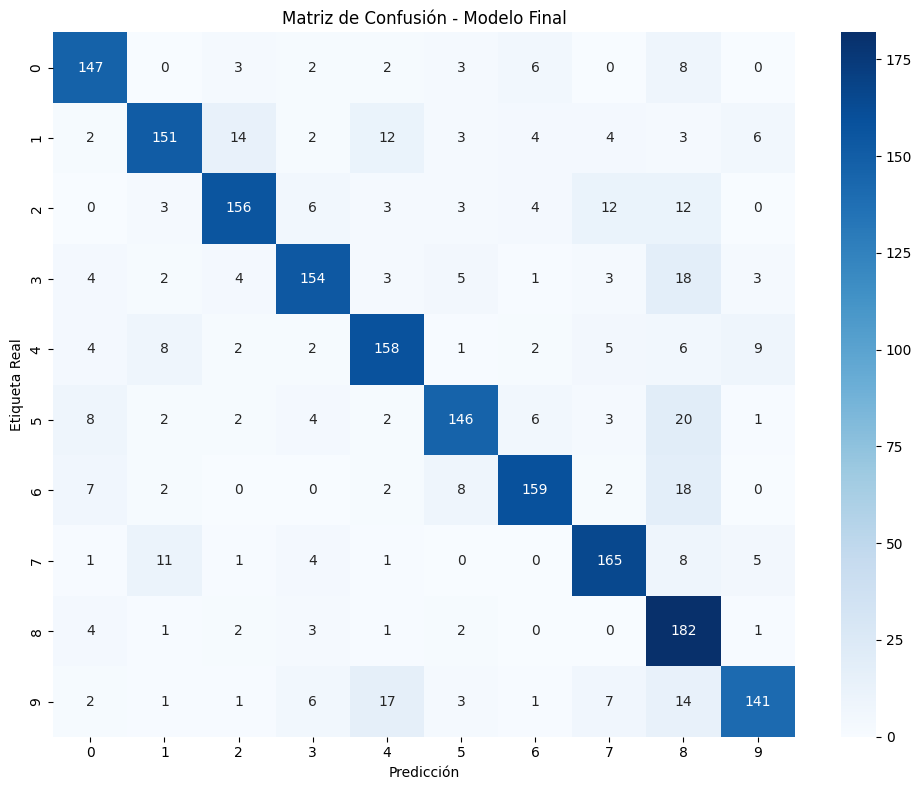

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.8212    0.8596    0.8400       171
           1     0.8343    0.7512    0.7906       201
           2     0.8432    0.7839    0.8125       199
           3     0.8415    0.7817    0.8105       197
           4     0.7861    0.8020    0.7940       197
           5     0.8391    0.7526    0.7935       194
           6     0.8689    0.8030    0.8346       198
           7     0.8209    0.8418    0.8312       196
           8     0.6298    0.9286    0.7505       196
           9     0.8494    0.7306    0.7855       193

    accuracy                         0.8028      1942
   macro avg     0.8134    0.8035    0.8043      1942
weighted avg     0.8134    0.8028    0.8039      1942



In [57]:
# Evaluación en test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28,28),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("Evaluación en conjunto de test:")
loss, acc = final_model.evaluate(test_generator, verbose=0)
print(f"Exactitud en Test: {acc:.4f}")
print(f"Pérdida en Test: {loss:.4f}")

# Guardar modelo
final_model.save('best_digit_classifier.h5')
print("Modelo final guardado como 'best_digit_classifier.h5'")

# Matriz de confusión y reporte final
preds = final_model.predict(test_generator, verbose=0)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusión - Modelo Final')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.tight_layout()
plt.show()

print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, digits=4))

In [58]:
# Análisis de errores comunes
print("Análisis de errores más comunes:")
error_rates = []
for i in range(10):
    total = np.sum(y_true == i)
    correct = np.sum((y_true == i) & (y_pred == i))
    error_rate = 1 - (correct / total) if total > 0 else 0
    error_rates.append((i, error_rate))

error_rates.sort(key=lambda x: x[1], reverse=True)
print("Dígitos con mayor tasa de error:")
for digit, error_rate in error_rates[:3]:
    print(f"  Dígito {digit}: {error_rate:.4f}")

Análisis de errores más comunes:
Dígitos con mayor tasa de error:
  Dígito 9: 0.2694
  Dígito 1: 0.2488
  Dígito 5: 0.2474


# Conclusión del Proyecto 
El modelo mejorado logró un rendimiento consistente de 80.28% en test, manteniendo la capacidad predictiva del modelo original mientras se espera una mejor generalización gracias a las técnicas de regularización implementadas. Los dígitos 9, 1 y 5 presentaron las mayores dificultades de clasificación, con tasas de error alrededor del 25%. El modelo demuestra un buen balance entre precisión y recall en la mayoría de las clases, con el dígito 8 mostrando el recall más alto (92.86%) pero la precisión más baja (62.98%), indicando cierta tendencia a confundirlo con otros dígitos. Los resultados validan la efectividad del enfoque para el reconocimiento de dígitos escritos a mano.